# Example notebook to show how the new chemical mixture creator works

In [1]:
import os
import sys
from pathlib import Path

In [2]:
vimms_path = '/Users/simon/git/vimms'
sys.path.append(vimms_path)
# path to fixtures so we can load HMDB
BASE_DIR = os.path.abspath(Path(vimms_path,'tests','integration', 'fixtures'))

In [3]:
%load_ext autoreload
%autoreload 2

from vimms.Common import *
from vimms.Controller import AIF
from vimms.Environment import Environment
from vimms.MassSpec import IndependentMassSpectrometer

# Noise for the MS
from vimms.Noise import GaussianPeakNoise,  UniformSpikeNoise

# Chemical creator import
from vimms.Chemicals import ChemicalMixtureCreator
from vimms.ChemicalSamplers import UniformRTAndIntensitySampler, UniformMS2Sampler, CRPMS2Sampler, GaussianChromatogramSampler, DatabaseFormulaSampler, UniformMZFormulaSampler, MGFMS2Sampler




Load HMDB

In [4]:
HMDB = load_obj(Path(BASE_DIR, 'hmdb_compounds.p'))

In [5]:
N_CHEMS = 10
MZ_RANGE = [(0, 1050)]
RT_RANGE = [(300, 500)]

In [6]:
# sample RT and log intensity uniformly. See class def for min and max log intensity
# returns actual intensity, but samples in log space
uu = UniformRTAndIntensitySampler(min_rt = 300, max_rt = 500)

# a sampler that samples MS2 uniform between 50 and the mass of the formula.
# number ofo MS2 peaks is poisson with mean poiss_peak_mean
us = UniformMS2Sampler(poiss_peak_mean=5)

# OR a CRP MS2 sampler
us = CRPMS2Sampler()

# OR load from an .mgf file - here we filter to only keep spectra with 20 peaks or fewer
# and sample without replacement
us = MGFMS2Sampler(Path(BASE_DIR,'small_mgf.mgf'), max_peaks=20, replace=False)

# generates Gaussian chromatograms
cs = GaussianChromatogramSampler()

# generates formulas from HMDB
hf = DatabaseFormulaSampler(HMDB)

# or, samples them from a uniform - so just mz rather then formulas
# resulting in UnknownChemical objects instead of known_chemical ones
hf = UniformMZFormulaSampler()

# The chemical mixture creator object

cm = ChemicalMixtureCreator(hf, rt_and_intensity_sampler=uu, 
                            adduct_prior_dict=ADDUCT_DICT_POS_MH,
                            chromatogram_sampler=cs,
                            ms2_sampler = us)

d = cm.sample(MZ_RANGE,RT_RANGE,N_CHEMS,2)

2020-08-26 22:26:48.900 | DEBUG    | vimms.ChemicalSamplers:__init__:142 - Loaded 9 spectra from /Users/simon/git/vimms/tests/integration/fixtures/small_mgf.mgf
2020-08-26 22:26:48.911 | DEBUG    | vimms.Chemicals:sample:604 - Sampled rt and intensity values and chromatograms


Loaded 100 spectra


Print the sampled chemicals, and their children

In [7]:
d.sort(key=lambda x: x.rt)
for chem in d:
    print(chem)
    for child in chem.children:
        print('\t',child)

UnknownChemical mz=360.5988 rt=312.50 max_intensity=55786.48
	 MSN Fragment mz=53.7009 ms_level=2
	 MSN Fragment mz=59.6485 ms_level=2
	 MSN Fragment mz=91.8826 ms_level=2
	 MSN Fragment mz=100.0998 ms_level=2
	 MSN Fragment mz=205.5794 ms_level=2
	 MSN Fragment mz=264.1518 ms_level=2
	 MSN Fragment mz=266.3645 ms_level=2
	 MSN Fragment mz=413.2683 ms_level=2
	 MSN Fragment mz=431.5265 ms_level=2
	 MSN Fragment mz=488.2986 ms_level=2
	 MSN Fragment mz=538.3387 ms_level=2
	 MSN Fragment mz=814.6830 ms_level=2
UnknownChemical mz=429.0090 rt=342.23 max_intensity=62563.57
	 MSN Fragment mz=51.3351 ms_level=2
	 MSN Fragment mz=56.5586 ms_level=2
	 MSN Fragment mz=59.6588 ms_level=2
	 MSN Fragment mz=64.1760 ms_level=2
	 MSN Fragment mz=66.9876 ms_level=2
	 MSN Fragment mz=72.1345 ms_level=2
	 MSN Fragment mz=83.9308 ms_level=2
	 MSN Fragment mz=98.0214 ms_level=2
	 MSN Fragment mz=110.7920 ms_level=2
	 MSN Fragment mz=313.5331 ms_level=2
	 MSN Fragment mz=393.7563 ms_level=2
	 MSN Fragment 

Create and run an example controller. In this case, AIF.

In [8]:
controller = AIF(MZ_RANGE[0][0],MZ_RANGE[0][1])
ionisation_mode = POSITIVE
scan_time_dict = {1:0.6,2:0.06}


mz_noise = GaussianPeakNoise(0.001)
intensity_noise = GaussianPeakNoise(0.1,log_space=True)

# This is new: spike noise which ensures no scans are empty
# first argument is density: how many spikes to sample per unit m/z. Second is max spike intensity
spike_noise = UniformSpikeNoise(0.01,1e3)


# note the None in the call in place of a peak sampler object - this isn't used anywhere in this example
mass_spec = IndependentMassSpectrometer(ionisation_mode, d, None,
                                        scan_duration_dict = scan_time_dict, 
                                        mz_noise = mz_noise,
                                        intensity_noise = intensity_noise,
                                        spike_noise = spike_noise)


In [9]:
env = Environment(mass_spec, controller, 300, 600, progress_bar=True)

In [10]:
set_log_level_warning()
# run the simulation
env.run()
env.write_mzML('.','test.mzML')

(600.000s) ms_level=1: 100%|█████████▉| 299.99999999999994/300 [00:05<00:00, 58.55it/s] 


# Example using new multi-sample

In [11]:
# make a 5 v 5 case control experiment
n_control = 5
n_case = 5

# create a list of groups -- this is the order the chemical lists will return in
group_list = ['control' for i in range(n_control)] + ['case' for i in range(n_case)]

# create a dictionary describing what we want to happen in the groups
# e.g. in the 'case' group, things are not missing, and 90% of them are changing
group_dict = {'case': {'missing_probability':0.0, 'changing_probability':0.9}}


from vimms.Chemicals import MultipleMixtureCreator
from vimms.Noise import GaussianPeakNoise

# use the intensity peak noise to add some sample noise
intensity_noise = GaussianPeakNoise(sigma=0.2,log_space=True)


# use the list of chemicals from the previous example
mmc = MultipleMixtureCreator(d, group_list, group_dict, intensity_noise = intensity_noise)
chem_lists = mmc.generate_chemical_lists()

Check the chemical lists produced with a heatmap


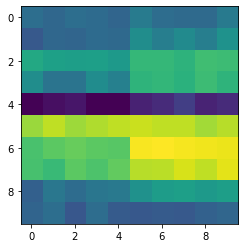

In [12]:
import pylab as plt
%matplotlib inline
intensities = []
for cl in chem_lists:
    new_intensities = [0 for c in d]
    for c in cl:
        c_pos = d.index(c.original_chemical)
        new_intensities[c_pos] = c.max_intensity
    intensities.append(new_intensities)
intensities = np.array(intensities).T
plt.imshow(np.log(intensities+1))